# Time Series Forecasting with LSTMs for Daily Coronavirus Cases using PyTorch in Python 

> This tutorial is NOT trying to build a model that predicts the Covid-19 outbreak/pandemic in the best way possible. This is an example of how you can use Recurrent Neural Networks on some real-world Time Series data with PyTorch. Hopefully, there are much better models that predict the number of daily confirmed cases.

Time series data captures a series of data points recorded at (usually) regular intervals. Some common examples include daily weather temperature, stock prices, and the number of sales a company makes.

Many classical methods (e.g. ARIMA) try to deal with Time Series data with varying success (not to say they are bad at it). In the last couple of years, [Long Short Term Memory Networks (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory) models have become a very useful method when dealing with those types of data.

Recurrent Neural Networks (LSTMs are one type of those) are very good at processing sequences of data. They can "recall" patterns in the data that are very far into the past (or future). In this tutorial, you're going to learn how to use LSTMs to predict future Coronavirus cases based on real-world data.

## Novel Coronavirus (COVID-19)

The novel Coronavirus (Covid-19) has spread around the world very rapidly. At the time of this writing, [Worldometers.info](https://www.worldometers.info/coronavirus/) shows that there are more than *95,488* confirmed cases in more than *84* countries.

The top 4 worst-affected (by far) are China (the source of the virus), South Korea, Italy, and Iran. Unfortunately, many cases are currently not reported due to:

- A person can get infected without even knowing (asymptomatic)
- Incorrect data reporting
- Not enough test kits
- The symptoms look a lot like the common flu

### How dangerous is this virus?

Except for the common statistics you might see cited on the news, there are some good and some bad news:

- More than 80% of the confirmed cases recover without any need of medical attention
- [3.4% Mortality Rate estimate by the World Health Organization (WHO) as of March 3](https://www.worldometers.info/coronavirus/coronavirus-death-rate/#who-03-03-20)
- The reproductive number which represents the average number of people to which a single infected person will transmit the virus is between 1.4 and 2.5 [(WHO's estimated on Jan. 23)](https://www.worldometers.info/coronavirus/#repro)

The last one is really scary. It sounds like we can witness some crazy exponential growth if appropriate measures are not put in place.

Let's get started!

In [5]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
#register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Daily Cases Dataset

The data is provided by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE) and contains the number of reported daily cases by country. [The dataset is available on GitHub](https://github.com/CSSEGISandData/COVID-19) and is updated regularly.

We're going to take the Time Series data only for confirmed cases (number of deaths and recovered cases are also available):

In [6]:
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv

--2023-04-15 16:50:42--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
正在解析主机 raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
正在连接 raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度： 17801222 (17M) [text/plain]
正在保存至: “time_series_covid19_confirmed_US.csv”

time_series_covid19 100%[===================>]  16.98M  69.3MB/s    用时 0.2s    

2023-04-15 16:50:44 (69.3 MB/s) - 已保存 “time_series_covid19_confirmed_US.csv” [17801222/17801222])



Or you can take the same dataset that I've used for this tutorial (data snapshot is from 8/10/2020) at ./time_series_covid19_confirmed_US.csv

## Data exploration & wrangling

Let's load the data and have a peek:

In [7]:
df = pd.read_csv('../data/time_series_covid19_confirmed_US.csv')
df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,19732,19759,19759,19759,19759,19759,19759,19759,19790,19790
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,69641,69767,69767,69767,69767,69767,69767,69767,69860,69860
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,7451,7474,7474,7474,7474,7474,7474,7474,7485,7485
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,8067,8087,8087,8087,8087,8087,8087,8087,8091,8091
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,18616,18673,18673,18673,18673,18673,18673,18673,18704,18704


Two things to note here:

- The data contains a province, country, latitude, and longitude. We won't be needing those.
- The number of cases is cumulative. We'll undo the accumulation.

Let's remove the location columns ...

In [8]:
df = df.iloc[:, 11:]
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,0,0,0,0,0,0,0,0,0,0,...,19732,19759,19759,19759,19759,19759,19759,19759,19790,19790
1,0,0,0,0,0,0,0,0,0,0,...,69641,69767,69767,69767,69767,69767,69767,69767,69860,69860
2,0,0,0,0,0,0,0,0,0,0,...,7451,7474,7474,7474,7474,7474,7474,7474,7485,7485
3,0,0,0,0,0,0,0,0,0,0,...,8067,8087,8087,8087,8087,8087,8087,8087,8091,8091
4,0,0,0,0,0,0,0,0,0,0,...,18616,18673,18673,18673,18673,18673,18673,18673,18704,18704


Let's check for missing values:

In [9]:
df.isnull().sum().sum()

0

Everything seems to be in place. Let's sum all rows, so we get the cumulative daily cases:

In [10]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22    1
2020-01-23    1
2020-01-24    2
2020-01-25    2
2020-01-26    5
dtype: int64

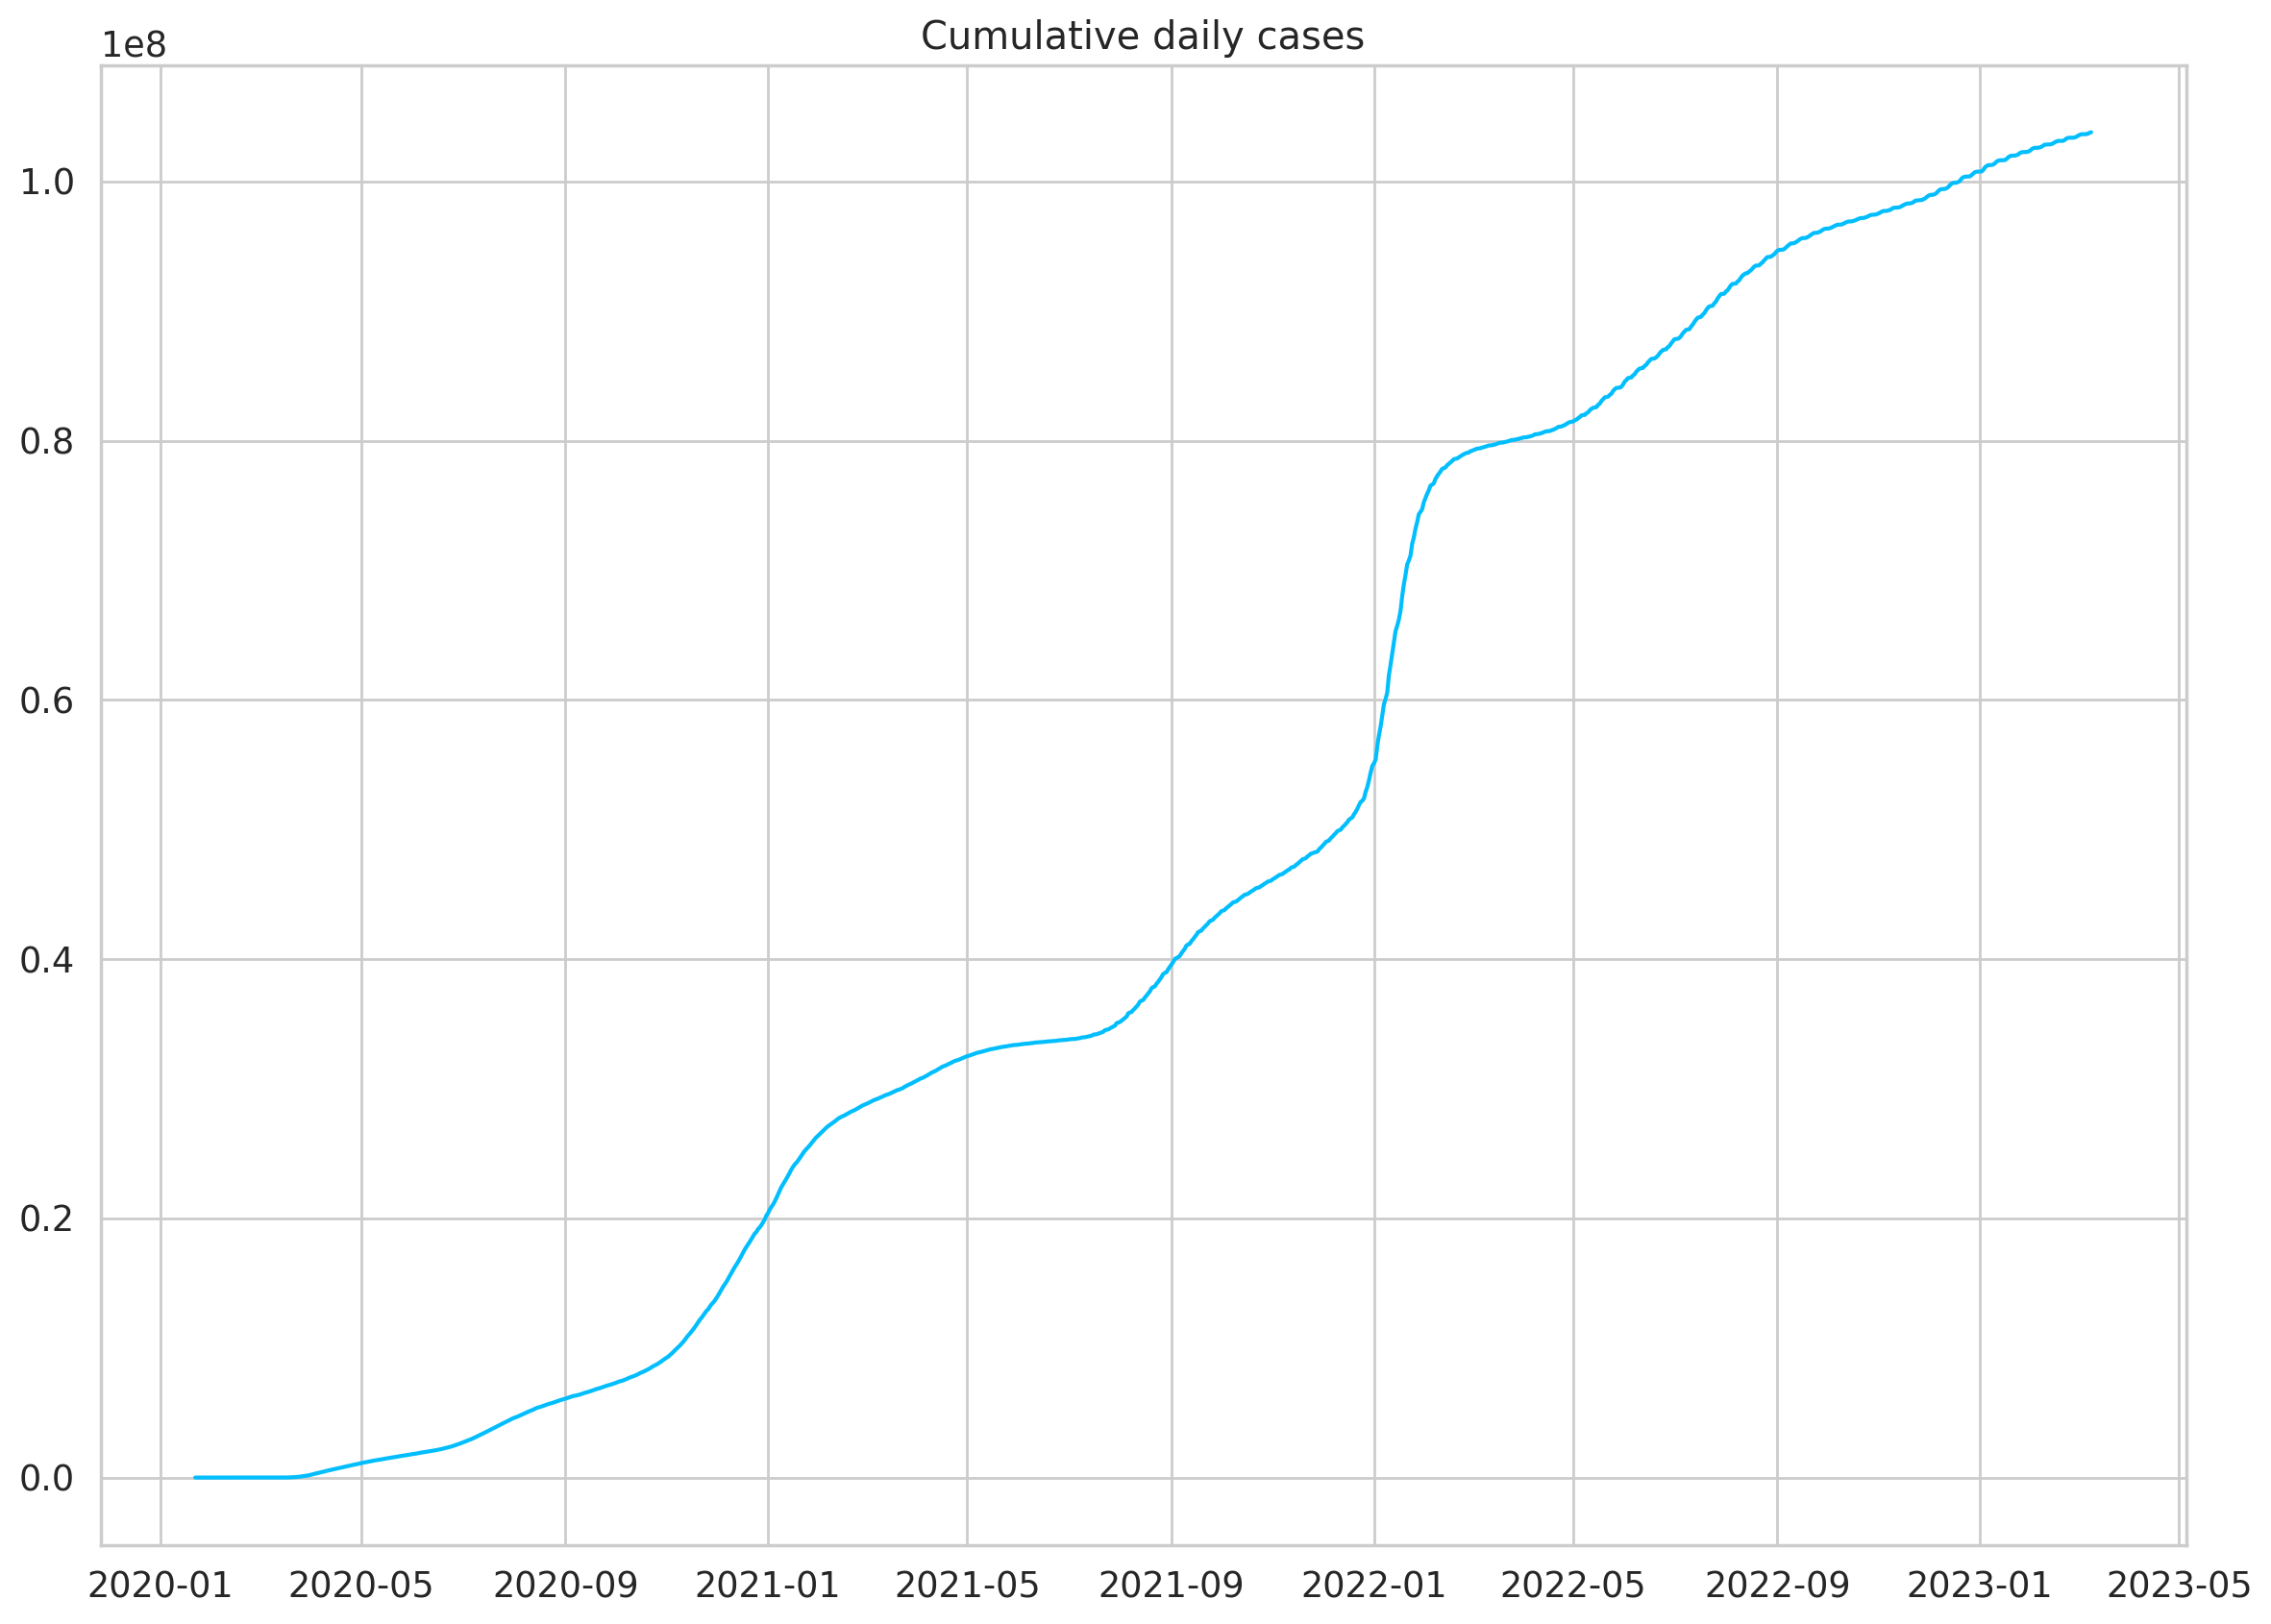

In [11]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases");

We'll undo the accumulation by subtracting the current value from the previous. We'll preserve the first value of the sequence:

In [12]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    1
2020-01-23    0
2020-01-24    1
2020-01-25    0
2020-01-26    3
dtype: int64

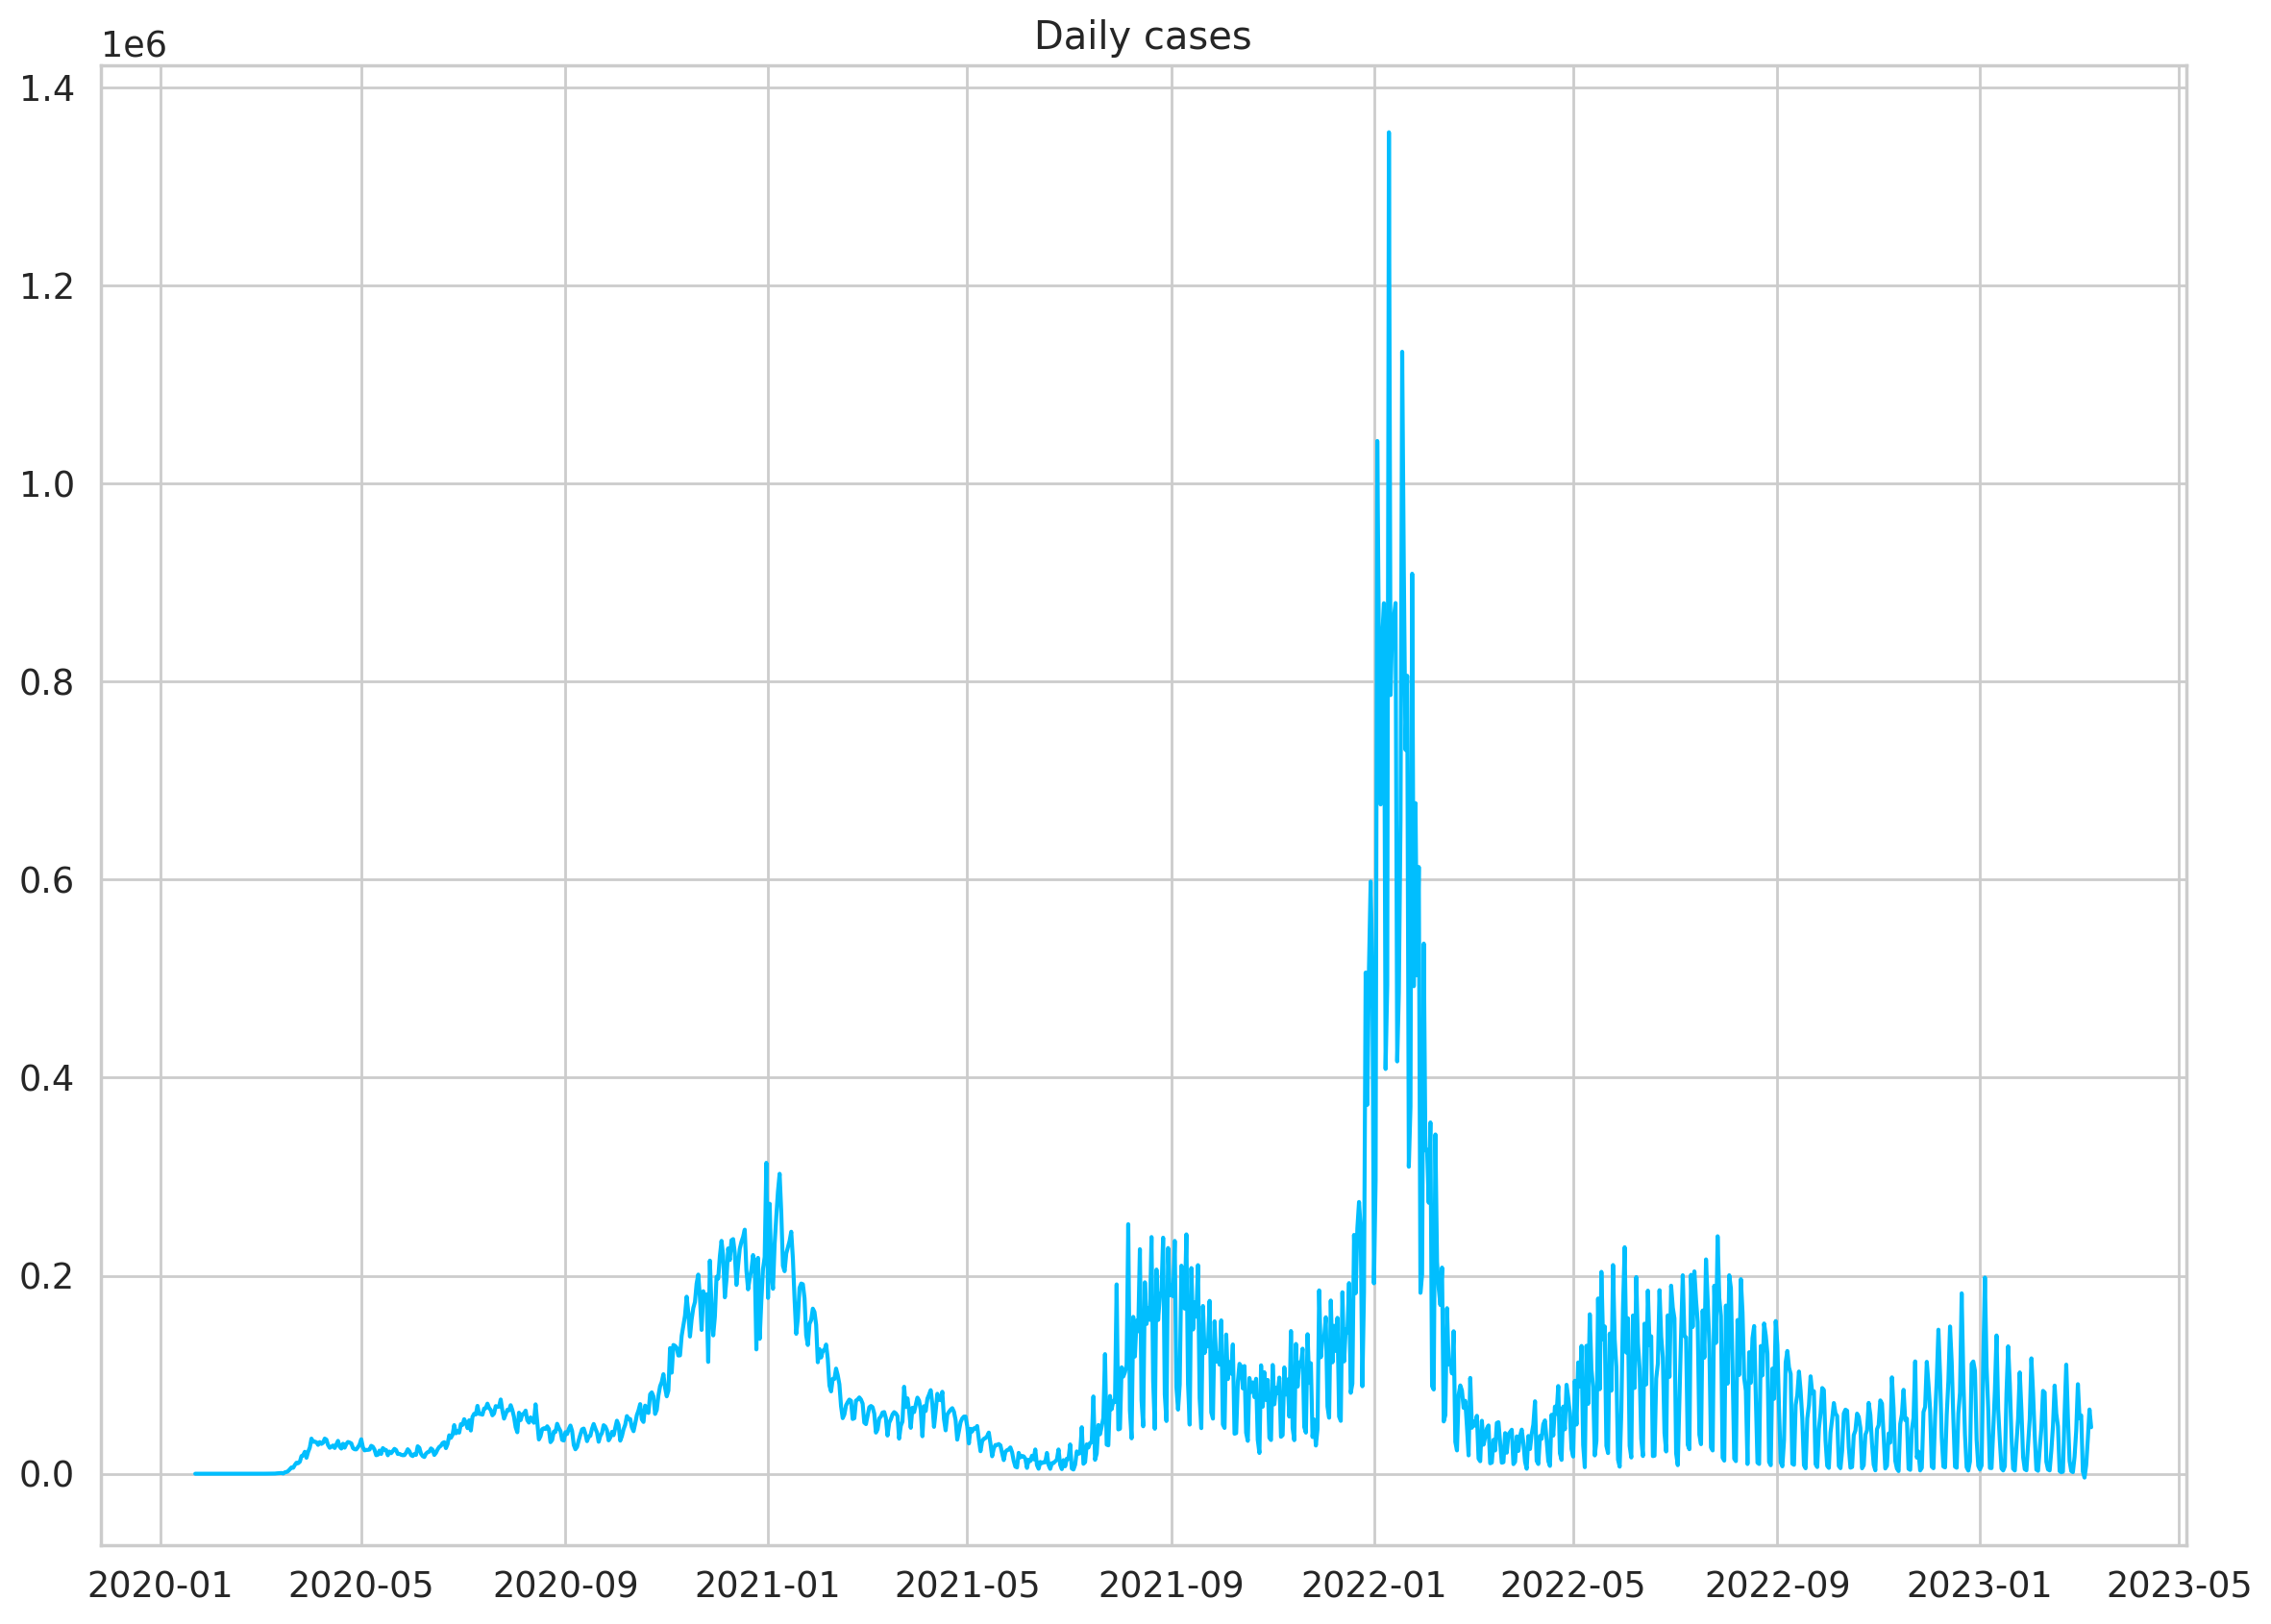

In [13]:
plt.plot(daily_cases)
plt.title("Daily cases");

The bi-modal distribution could be a challenge for our model. Let's check the amount of data we have:

In [14]:
days = daily_cases.shape[0]

print('We have data for ' + str(days) + ' days. Lets see what we can do with it ...')

We have data for 1143 days. Lets see what we can do with it ...


## Preprocessing

We'll use 14 days for testing and the rest for training:

In [176]:
test_data_size = 28

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape

(1115,)

We have to scale the data (values will be between 0 and 1) if we want to increase the training speed and performance of the model. We'll use the `MinMaxScaler` from scikit-learn:

In [177]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

Currently, we have a big sequence of daily cases. We'll convert it into smaller ones:

In [178]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [179]:
seq_length = 14
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

Each training example contains a sequence of 5 data points of history and a label for the real value that our model needs to predict. Let's dive in:

In [180]:
X_train.shape

torch.Size([1100, 14, 1])

In [181]:
X_train[:2]

tensor([[[7.3828e-07],
         [0.0000e+00],
         [7.3828e-07],
         [0.0000e+00],
         [2.2148e-06],
         [0.0000e+00],
         [0.0000e+00],
         [7.3828e-07],
         [0.0000e+00],
         [1.4766e-06],
         [0.0000e+00],
         [0.0000e+00],
         [2.2148e-06],
         [0.0000e+00]],

        [[0.0000e+00],
         [7.3828e-07],
         [0.0000e+00],
         [2.2148e-06],
         [0.0000e+00],
         [0.0000e+00],
         [7.3828e-07],
         [0.0000e+00],
         [1.4766e-06],
         [0.0000e+00],
         [0.0000e+00],
         [2.2148e-06],
         [0.0000e+00],
         [0.0000e+00]]])

In [182]:
y_train.shape

torch.Size([1100, 1])

In [183]:
y_train[:2]

tensor([[0.0000e+00],
        [7.3828e-07]])

In [184]:
train_data[:10]

array([[7.38275448e-07],
       [0.00000000e+00],
       [7.38275448e-07],
       [0.00000000e+00],
       [2.21482634e-06],
       [0.00000000e+00],
       [0.00000000e+00],
       [7.38275448e-07],
       [0.00000000e+00],
       [1.47655090e-06]])

## Building a model

We'll encapsulate the complexity of our model into a class that extends from `torch.nn.Module`:

In [185]:

class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )
    self.hidden = (self.hidden[0].to(self.device), self.hidden[1].to(self.device))

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

Our `CoronaVirusPredictor` contains 3 methods:
- constructor - initialize all helper data and create the layers
- `reset_hidden_state` - we'll use a stateless LSTM, so we need to reset the state after each example
- `forward` - get the sequences, pass all of them through the LSTM layer, at once. We take the output of the last time step and pass it through our linear layer to get the prediction.

## Training

Let's build a helper function for the training of our model (we'll reuse it later):

In [190]:

def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='mean')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=1, gamma=0.5)
  num_epochs = 200

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(1,num_epochs+1):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
    scheduler.step()
  
  return model.eval(), train_hist, test_hist

Note that the hidden state is reset at the start of each epoch. We don't use batches of data our model sees every example at once. We'll use mean squared error to measure our training and test error. We'll record both. 

Let's create an instance of our model and train it:

In [191]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=5
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
model = model.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Using cuda device
Epoch 0 train loss: 0.011813552118837833 test loss: 0.0005656417342834175
Epoch 10 train loss: 0.009173277765512466 test loss: 0.0042072259820997715
Epoch 20 train loss: 0.00913449190557003 test loss: 0.00409016152843833
Epoch 30 train loss: 0.009136884473264217 test loss: 0.004293451551347971
Epoch 40 train loss: 0.00914984755218029 test loss: 0.004191828425973654
Epoch 50 train loss: 0.009189759381115437 test loss: 0.004238960333168507
Epoch 60 train loss: 0.00916103832423687 test loss: 0.0042489259503781796
Epoch 70 train loss: 0.009145112708210945 test loss: 0.004248803947120905
Epoch 80 train loss: 0.00913432240486145 test loss: 0.00422102864831686
Epoch 90 train loss: 0.009155415929853916 test loss: 0.004201044328510761
Epoch 100 train loss: 0.009145318530499935 test loss: 0.00422107195481658
Epoch 110 train loss: 0.009130660444498062 test loss: 0.004192085936665535
Epoch 120 train loss: 0.009150486439466476 test loss: 0.004205755889415741
Epoch 130 train loss: 

Let's have a look at the train and test loss:

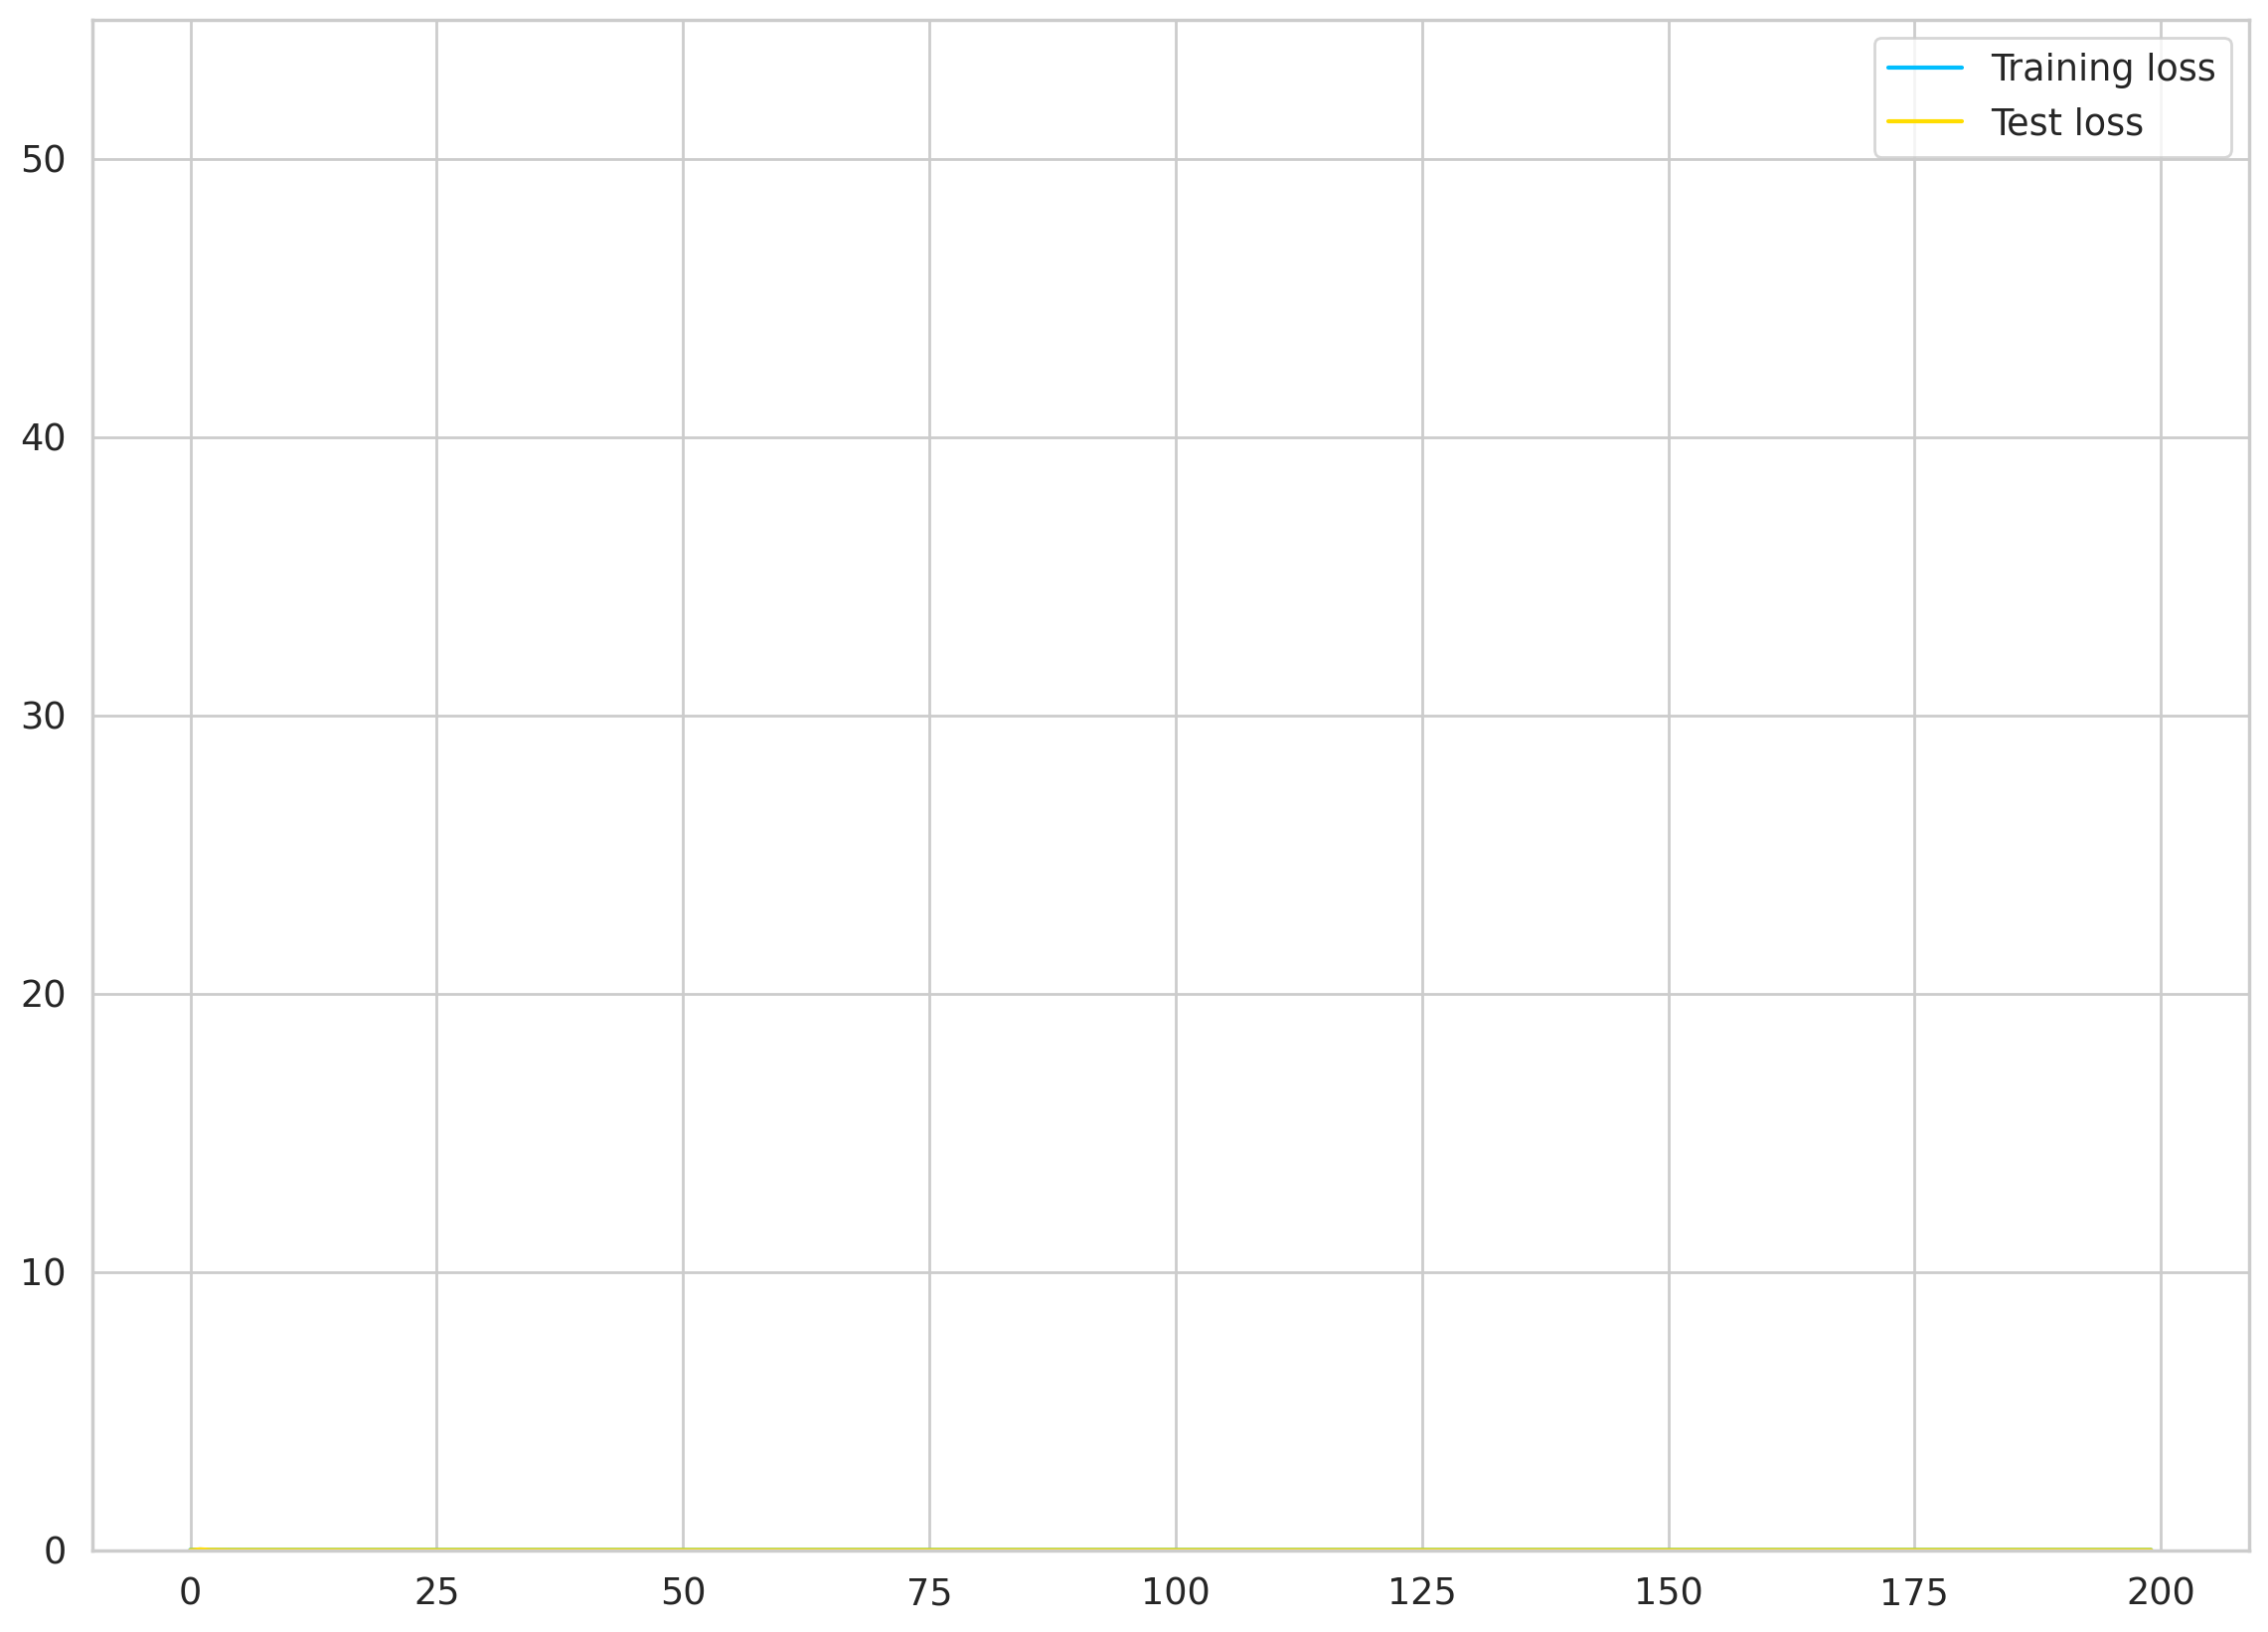

In [192]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
#plt.ylim((0, 55))
plt.legend();

Our model's performance doesn't improve after 40 epochs or so. Recall that we have very little data. Maybe we shouldn't trust our model that much?

## Predicting daily cases

Our model can (due to the way we've trained it) predict only a single day in the future. We'll employ a simple strategy to overcome this limitation. Use predicted values as input for predicting the next days:

In [193]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.cpu().numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float().cuda()

We have to reverse the scaling of the test data and the model predictions:

In [194]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.cpu().flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

Let's look at the results:

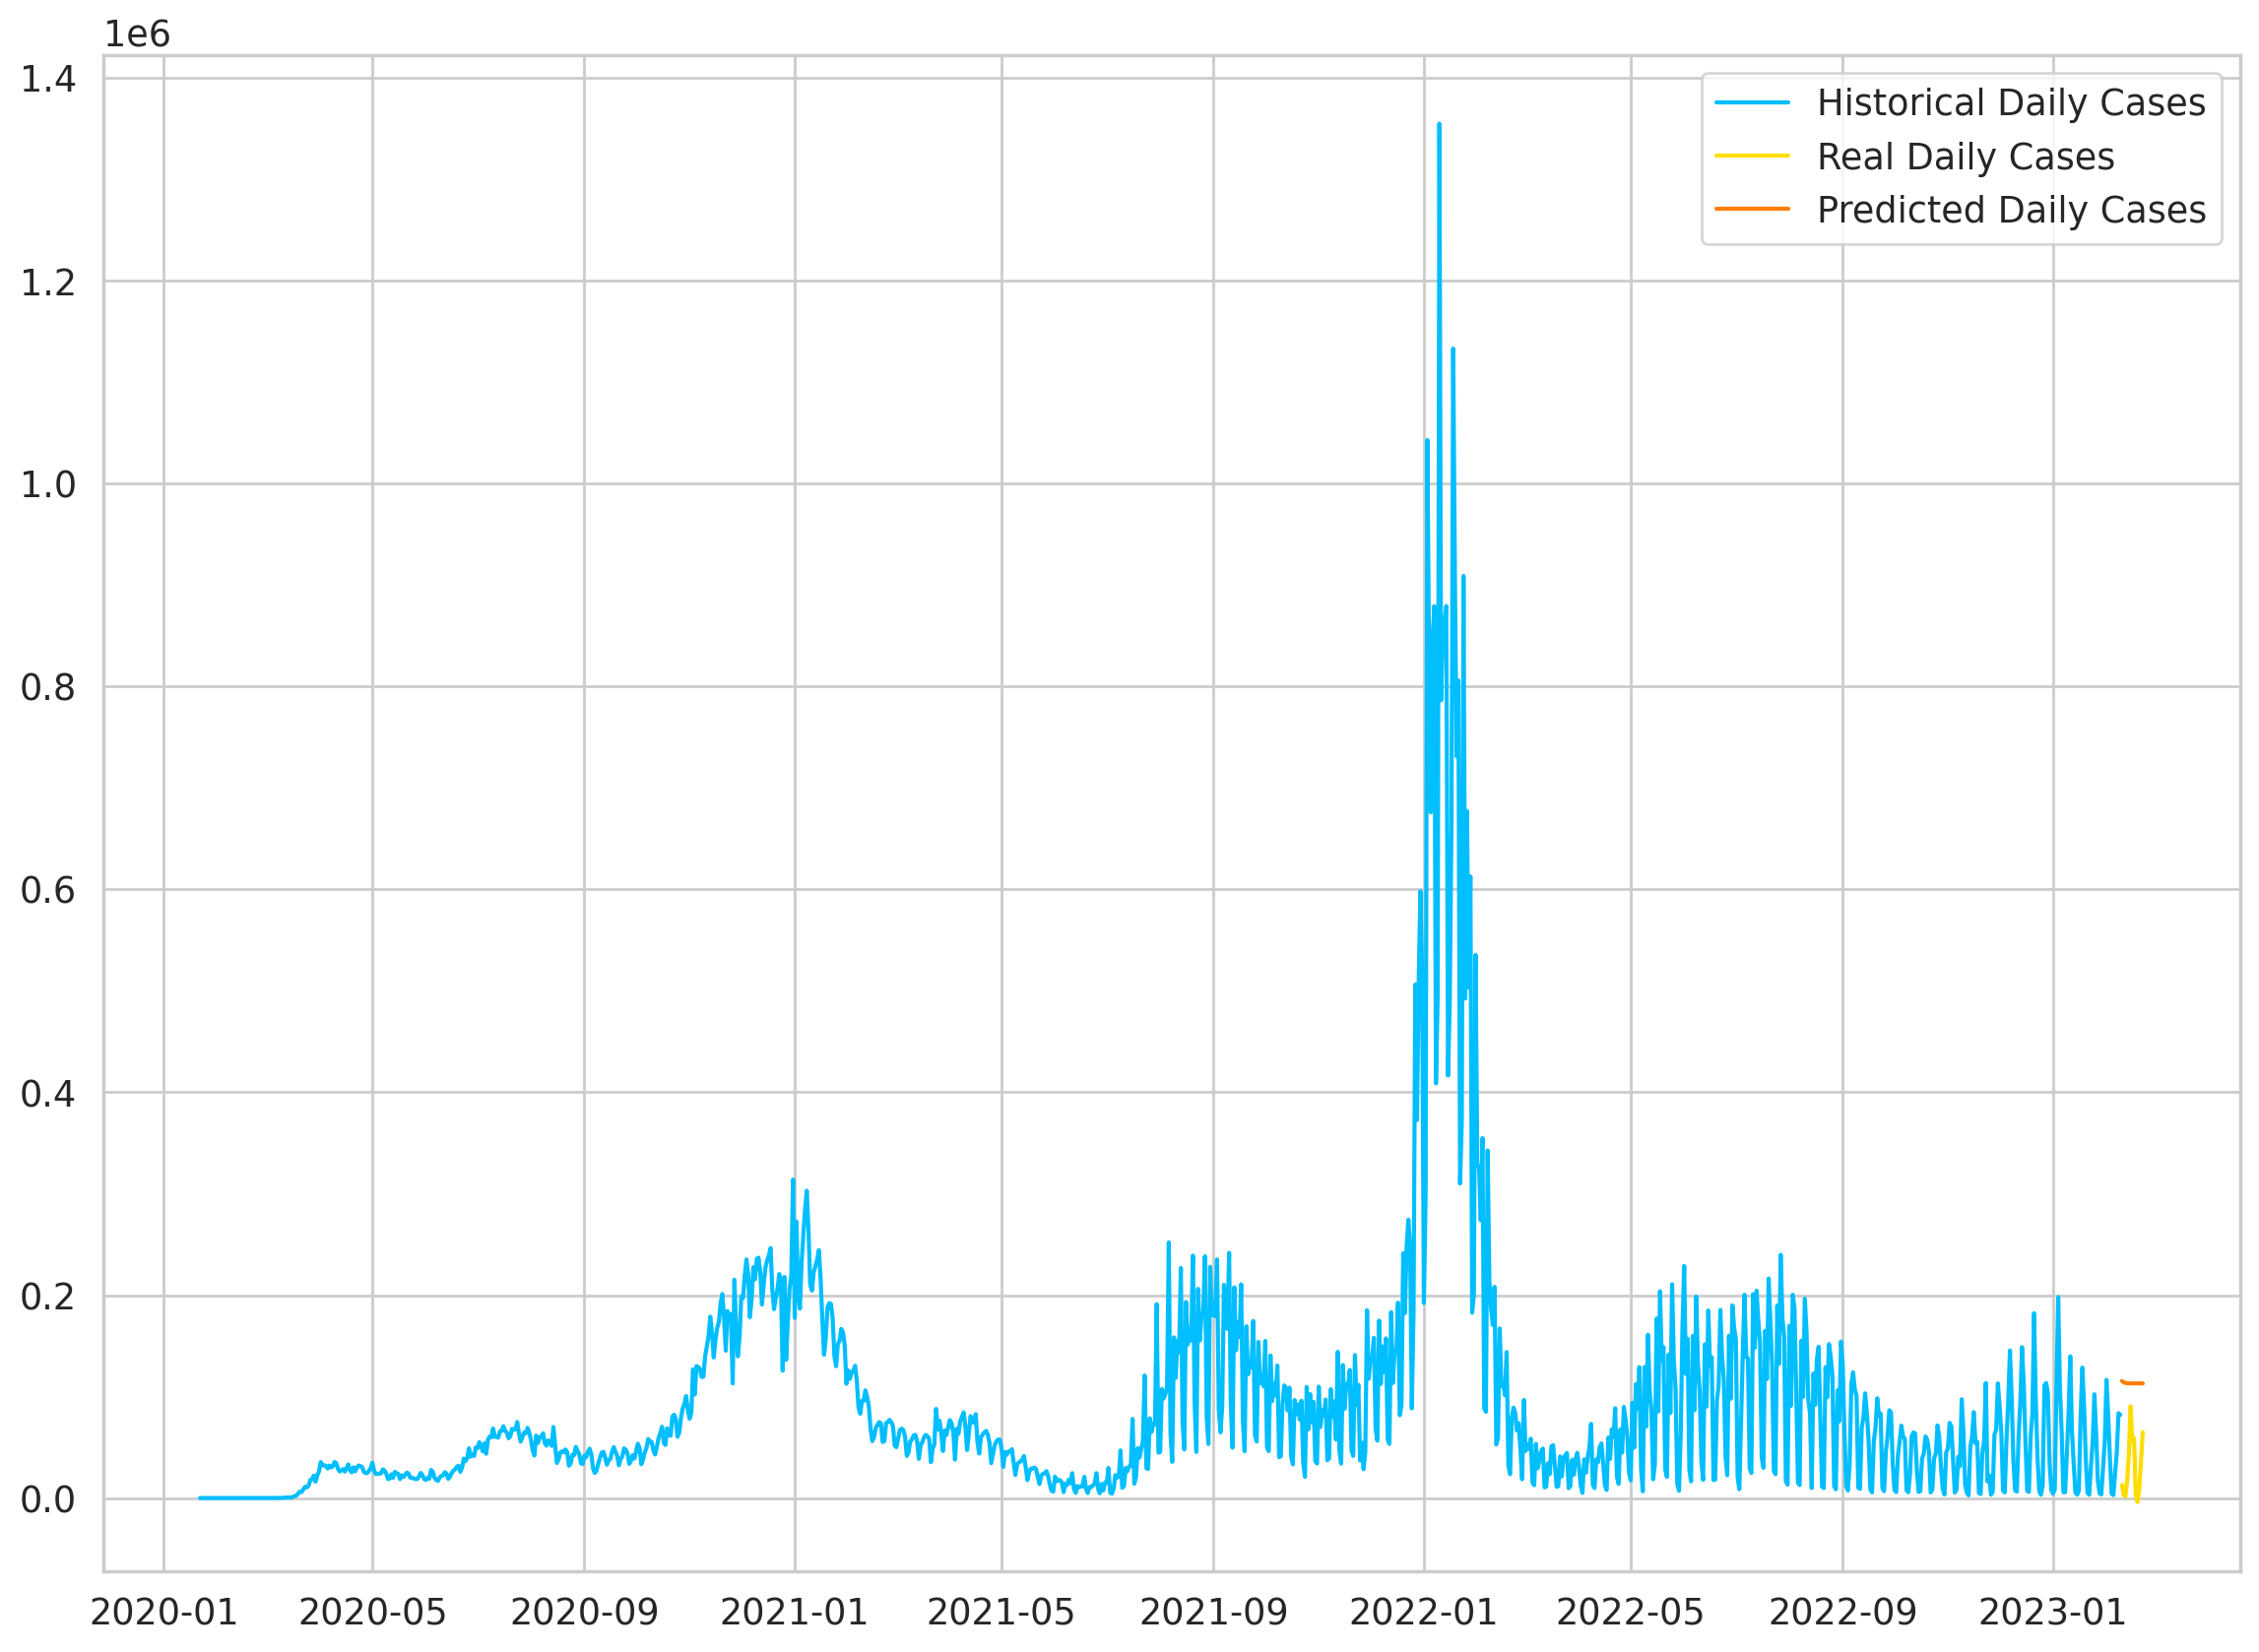

In [195]:
plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();

As expected, our model doesn't perform very well. That said, the predictions seem to be in the right ballpark (probably due to using the last data point as a strong predictor for the next).

## Use all data for training

Now, we'll use all available data to train the same model:

In [196]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

(1143, 1)

The preprocessing and training steps are the same:

In [197]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=5
)
model = model.to(device)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 0.010602944530546665
Epoch 10 train loss: 0.009218480437994003
Epoch 20 train loss: 0.009211801923811436
Epoch 30 train loss: 0.009215936064720154
Epoch 40 train loss: 0.009210493415594101
Epoch 50 train loss: 0.009231523610651493
Epoch 60 train loss: 0.00920321885496378
Epoch 70 train loss: 0.009219623170793056
Epoch 80 train loss: 0.00923160556703806
Epoch 90 train loss: 0.009195582009851933
Epoch 100 train loss: 0.009203224442899227
Epoch 110 train loss: 0.009220198728144169
Epoch 120 train loss: 0.009246407076716423
Epoch 130 train loss: 0.009215337224304676
Epoch 140 train loss: 0.00920808780938387
Epoch 150 train loss: 0.009206402115523815
Epoch 160 train loss: 0.009209936484694481
Epoch 170 train loss: 0.009244955144822598
Epoch 180 train loss: 0.009192178957164288
Epoch 190 train loss: 0.009225063025951385


## Predicting future cases

We'll use our "fully trained" model to predict the confirmed cases for 12 days into the future:

In [198]:
DAYS_TO_PREDICT = 7

with torch.no_grad():
  test_seq = X_all[:1]
  test_seq = test_seq.to(device)
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.cpu().numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float().cuda()

As before, we'll inverse the scaler transformation:

In [199]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

To create a cool chart with the historical and predicted cases, we need to extend the date index of our data frame:

In [200]:
daily_cases.index[-1]

Timestamp('2023-03-09 00:00:00')

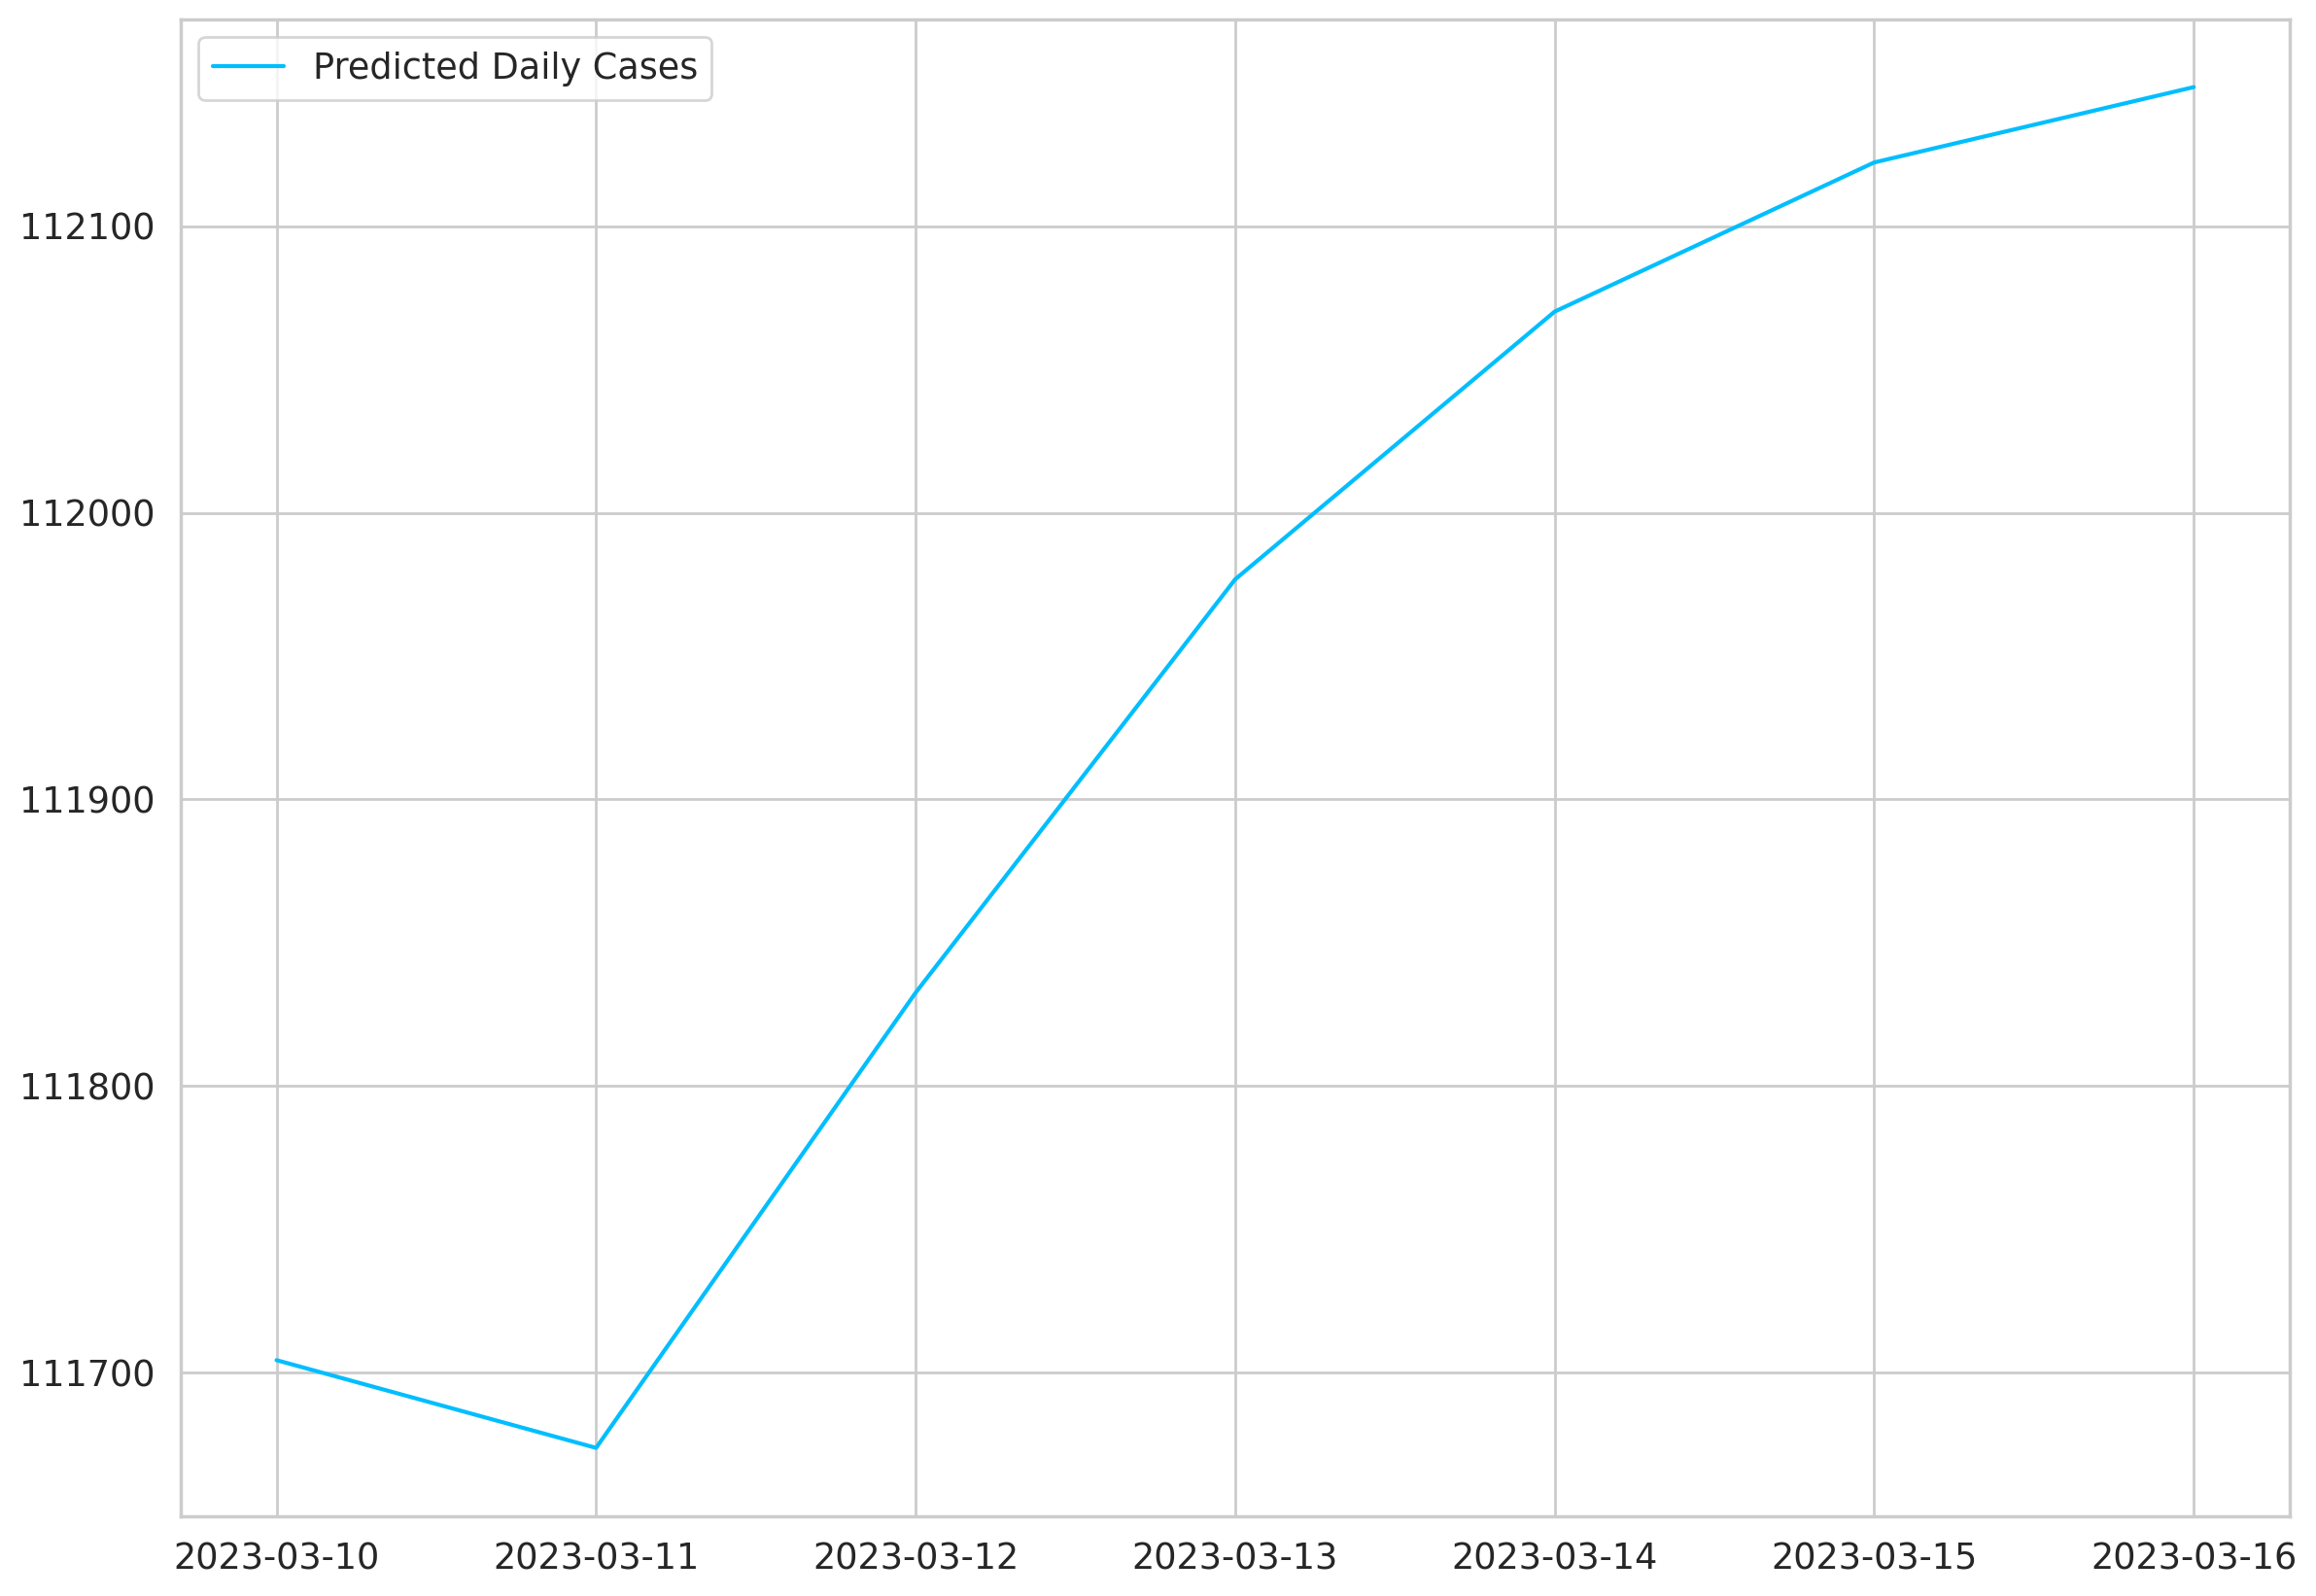

In [201]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

Now we can use all the data to plot the results:

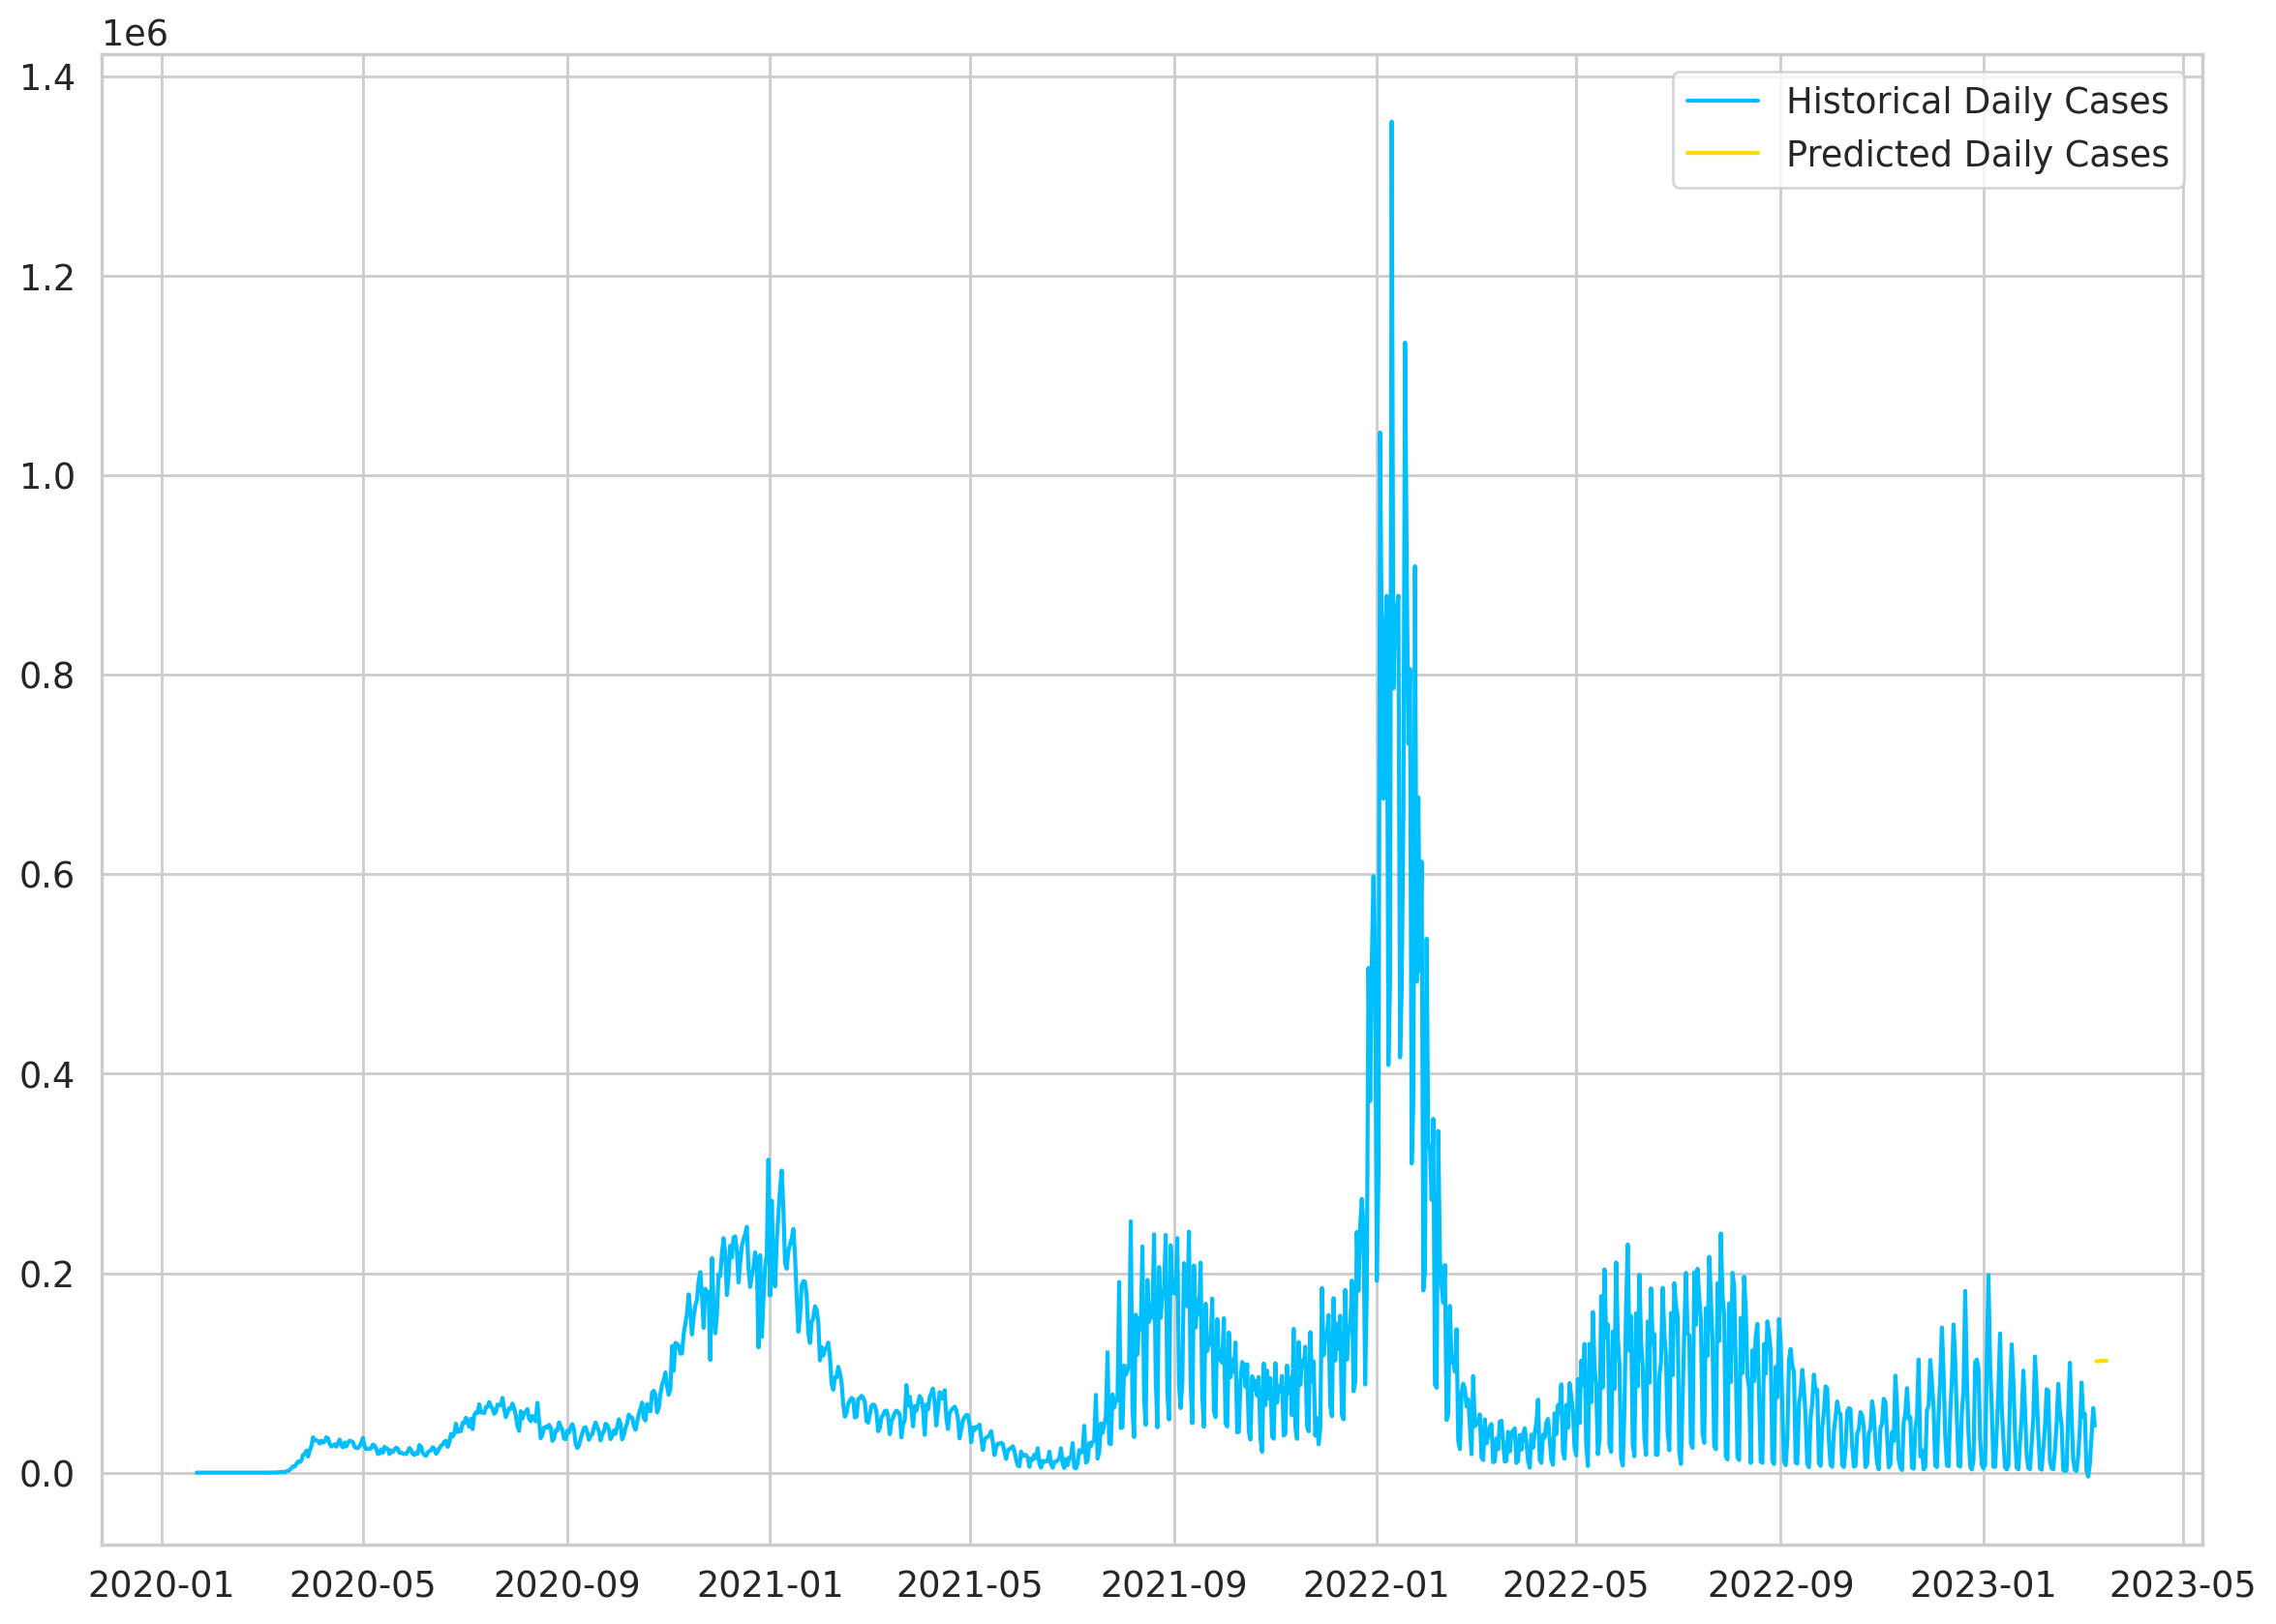

In [202]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

Our model thinks that things will level off. Note that the more you go into the future, the more you shouldn't trust your model predictions.

## References

- [Sequence Models PyTorch Tutorial](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)
- [LSTM for time series prediction](https://towardsdatascience.com/lstm-for-time-series-prediction-de8aeb26f2ca)
- [Time Series Prediction using LSTM with PyTorch in Python](https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/)
- [Stateful LSTM in Keras](https://philipperemy.github.io/keras-stateful-lstm/)
- [LSTMs for Time Series in PyTorch](https://www.jessicayung.com/lstms-for-time-series-in-pytorch/)
- [Novel Coronavirus (COVID-19) Cases, provided by JHU CSSE](https://github.com/CSSEGISandData/COVID-19)
- [covid-19-analysis](https://github.com/AaronWard/covid-19-analysis)
- [How does Coronavirus compare to Ebola, SARS, etc?](https://www.youtube.com/watch?v=6dDD2tHWWnU)
- [Worldometer COVID-19 Coronavirus Outbreak](https://www.worldometers.info/coronavirus/)
- [How contagious is the Wuhan Coronavirus? (Ro)](https://www.worldometers.info/coronavirus/#repro)
- [Systemic Risk of Pandemic via Novel Pathogens - Coronavirus: A Note](https://www.academia.edu/41743064/Systemic_Risk_of_Pandemic_via_Novel_Pathogens_-_Coronavirus_A_Note)
- [Statistical Consequences of Fat Tails: Real World Preasymptotics, Epistemology, and Applications](https://www.researchers.one/article/2020-01-21)
